<a href="https://colab.research.google.com/github/eyaguirat10/CoWin-Breast-Cancer-Detection/blob/eya/Eya_Guirat_Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Business Understanding

## **Problem Statement**

Breast cancer diagnosis often depends on manual interpretation of medical measurements, which can lead to delays or inconsistencies in detecting malignant tumors. Hospitals need a reliable way to support clinicians with **fast, objective, and accurate assessments** based on patient data. By analyzing tumor characteristics extracted from the **Wisconsin Diagnostic Breast Cancer dataset**, this project seeks to build a system that improves early detection and reduces diagnostic errors.



---

## **Business Objective (BO)**

1.  ### Determine whether a tumor is malignant or benign based on morphological data extracted from breast tissue imagery, in order to assist clinicians in initial diagnosis.


2.  ### Characterize and differentiate malignant tumor profiles into distinct groups based on their severity or aggressiveness, enabling more targeted follow-up strategies.
   
3.  ### Propose individualized recommendations for new patients by comparing their physiological and biochemical profiles to previously identified cancer risk patterns.  

---

## **Data Science Objectives (DSO)**

1.  ### Develop a classification system that distinguishes between benign and malignant tumors using morphological features from the WDBC dataset and evaluate its accuracy using appropriate performance metrics.


2.  ### Identify natural groupings within malignant tumor cases using unsupervised clustering techniques in order to define clinically relevant cancer subtypes.
   
3.  ### Implement a recommendation system that maps new patient profiles (from the Coimbra dataset) to known cluster patterns and delivers personalized insights based on proximity to known cancer risk profiles.

### DSO1: Predict the diagnosis type — **M (Malignant)** or **B (Benign)**

| Modèles             | Liste des variables | Liste des paramètres |
|---------------------|---------------------|-----------------------|
| GRU SVM             |                     |                       |
| SVM                 |                     |                       |
| Linear Regression   |                     |                       |
| MLP                 |                     |                       |
| Nearest Neighbor    |                     |                       |
| Softmax Regression  |                     |                       |
| XGBOOST (new)       |                     |                       |
| Random Forest (new) |                     |                       |


### DSO2: Cluster diagnosis patterns

| Modèles                | Liste des variables | Liste des paramètres |
|------------------------|---------------------|-----------------------|
| Kmeans                 |                     |                       |
| DBSCAN                 |                     |                       |
| Gaussian Mixture Model |                     |                       |


### DSO3: Cluster-based recommendation system

| Modèles               | Liste des variables | Liste des paramètres |
|------------------------|---------------------|-----------------------|
| KNeighborsClassifier   |                     |                       |
| DecisionTreeClassifier |                     |                       |
| Apriori                |                     |                       |


# II. Data Understanding

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
print("Dimensions :", df.shape)
print("Colonnes :", df.columns.tolist())
print("\nTypes :", df.dtypes)

Dimensions : (569, 33)
Colonnes : ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Types : id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              

In [ ]:
print(df.head())
print(df.tail())
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Missing values
             Missing Count  Missing Percentage
Unnamed: 32            569               100.0


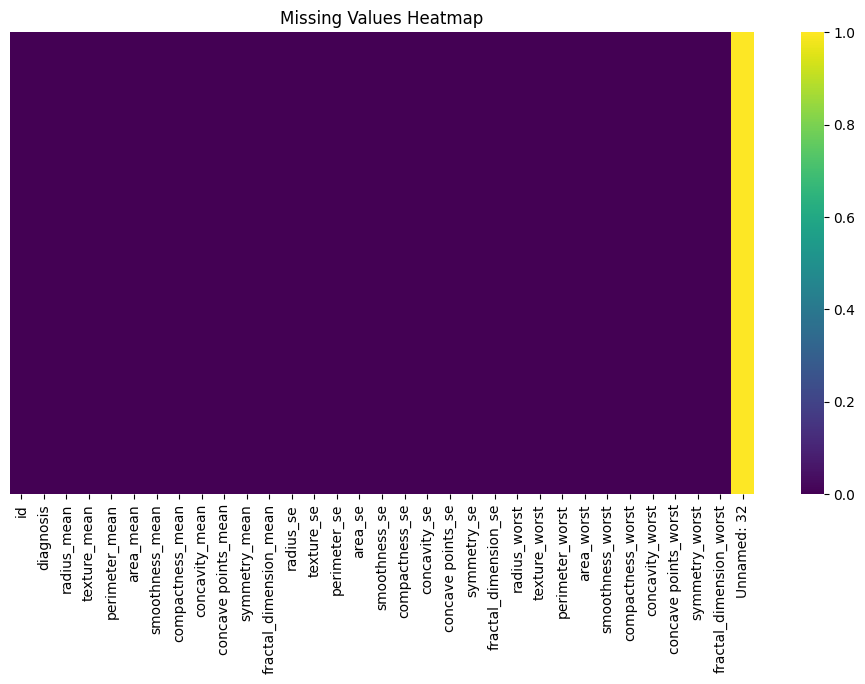

In [ ]:
print("Missing values")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])


plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
print("Basic statistics")
print(df.describe())

# For the diagnosis column specifically
print("\n Diagnosis distribution")
print(df['diagnosis'].value_counts())
print(f"Malignant Percentage: {(df['diagnosis'] == 'M').mean()*100:.2f}%")

Basic statistics
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064      

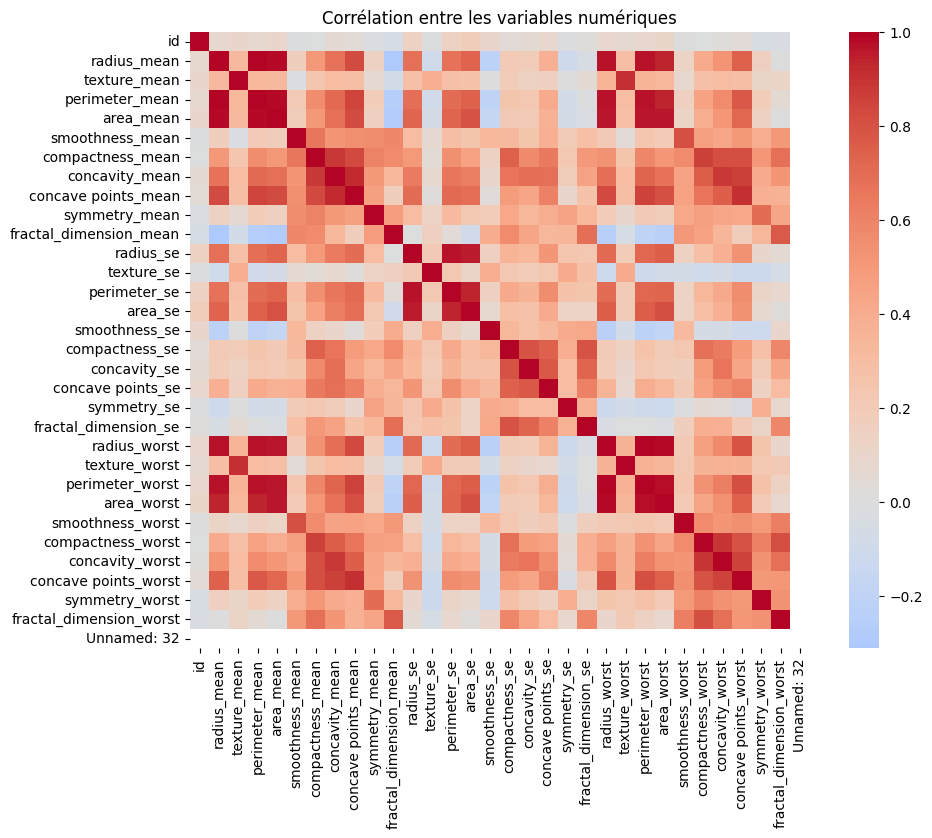

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Corrélation entre les variables numériques")
plt.show()

Outlier detection
Outliers in key features:
id: 81 outliers
radius_mean: 14 outliers
texture_mean: 7 outliers
perimeter_mean: 13 outliers
area_mean: 25 outliers


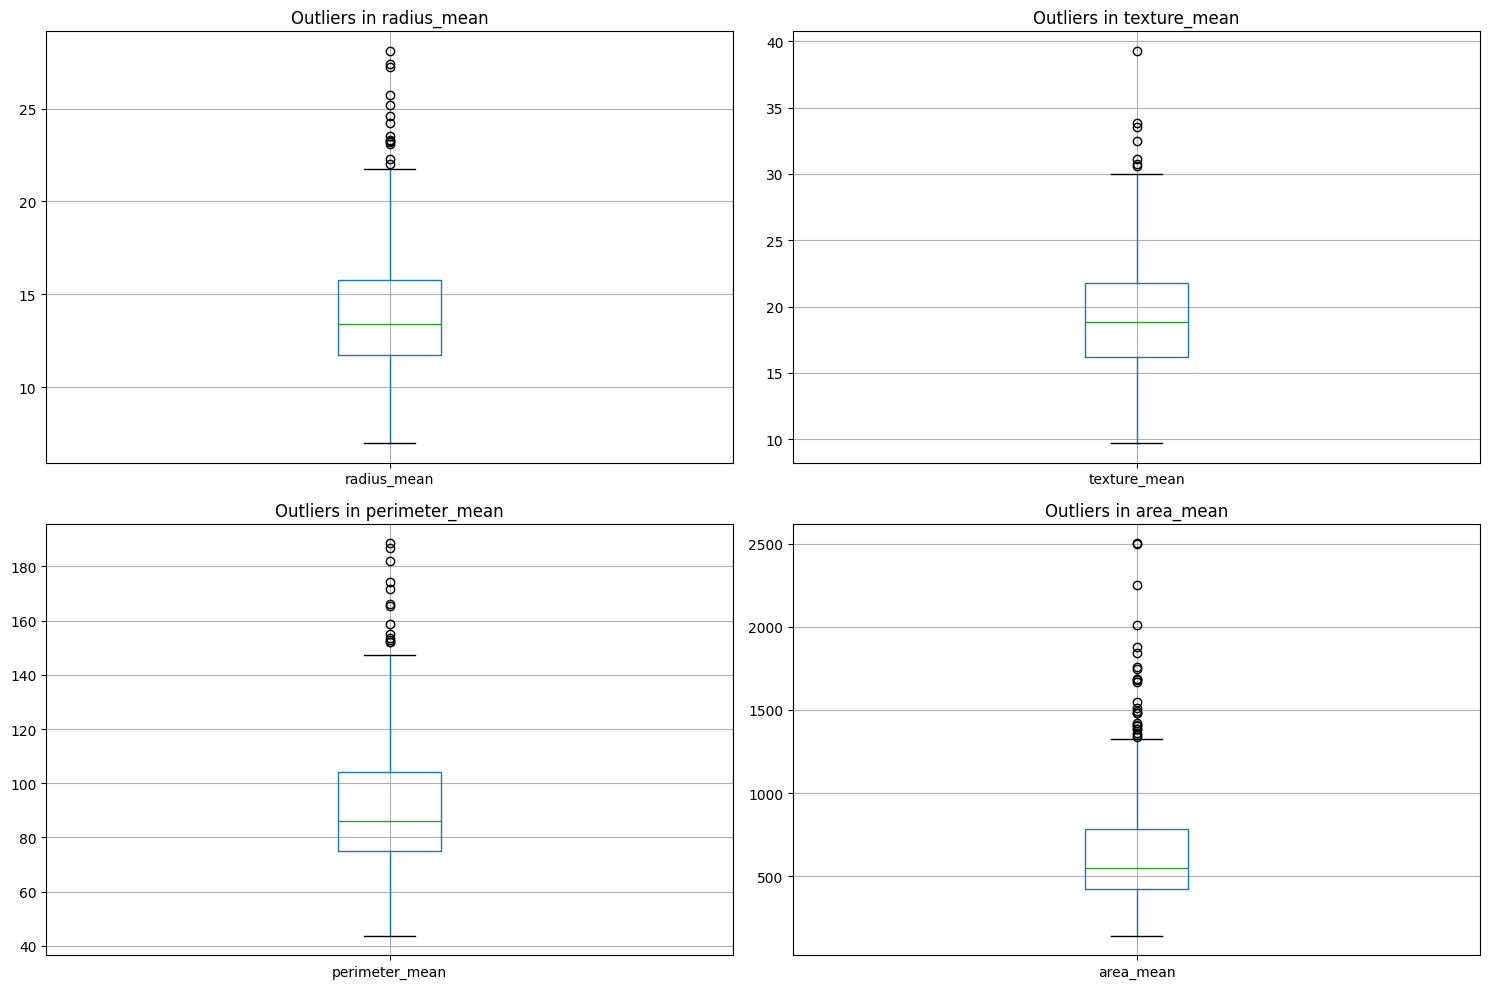

In [ ]:
print("Outlier detection")

# Method 1: IQR for numerical columns
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Check outliers in key numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

print("Outliers in key features:")
for col in numerical_cols[:5]:  # Check first 5 numerical columns
    outliers = detect_outliers_iqr(df[col])
    print(f"{col}: {len(outliers)} outliers")

# Visualize outliers for key features
key_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    df.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f'Outliers in {feature}')

plt.tight_layout()
plt.show()

In [ ]:
print("Data quality summary")
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for constant columns (columns with only one value)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Constant columns: {constant_cols}")

# Check for columns with too many zeros
print("\n columns with many zeros")
for col in numerical_cols:
    zero_percent = (df[col] == 0).mean() * 100
    if zero_percent > 50:  # Show columns with more than 50% zeros
        print(f"{col}: {zero_percent:.2f}% zeros")

Data quality summary
Total records: 569
Total features: 33
Duplicate rows: 0
Constant columns: []

 columns with many zeros


Target variable analysis


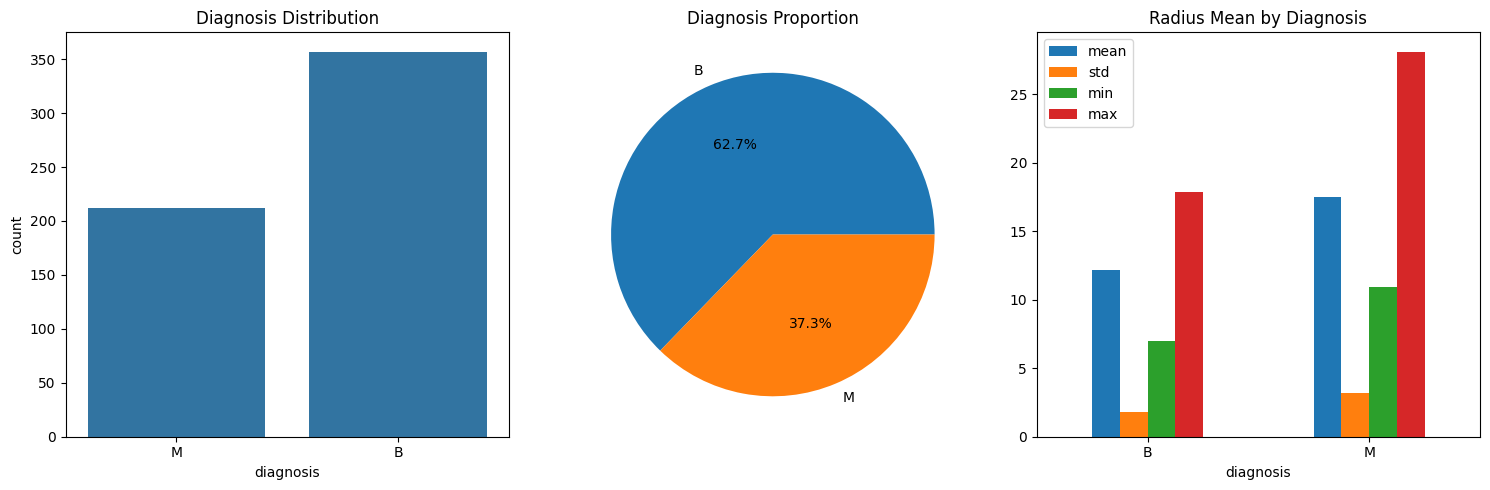

Diagnosis value counts:
diagnosis
B    357
M    212
Name: count, dtype: int64


In [ ]:
print("Target variable analysis")
diagnosis_counts = df['diagnosis'].value_counts()

plt.figure(figsize=(15, 5))

# Subplot 1: Count plot
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='diagnosis')
plt.title('Diagnosis Distribution')

# Subplot 2: Pie chart
plt.subplot(1, 3, 2)
plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index, autopct='%1.1f%%')
plt.title('Diagnosis Proportion')

# Subplot 3: Statistics by diagnosis
plt.subplot(1, 3, 3)
diagnosis_stats = df.groupby('diagnosis')['radius_mean'].agg(['mean', 'std', 'min', 'max'])
diagnosis_stats.plot(kind='bar', ax=plt.gca())
plt.title('Radius Mean by Diagnosis')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"Diagnosis value counts:\n{diagnosis_counts}")

Correlation analysis
Top 10 features correlated with diagnosis:
diagnosis_numeric       1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
Name: diagnosis_numeric, dtype: float64

 Bottom 10 features correlated with diagnosis:
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
id                         0.039769
symmetry_se               -0.006522
texture_se                -0.008303
fractal_dimension_mean    -0.012838
smoothness_se             -0.067016
Unnamed: 32                     NaN
Name: diagnosis_numeric, dtype: float64


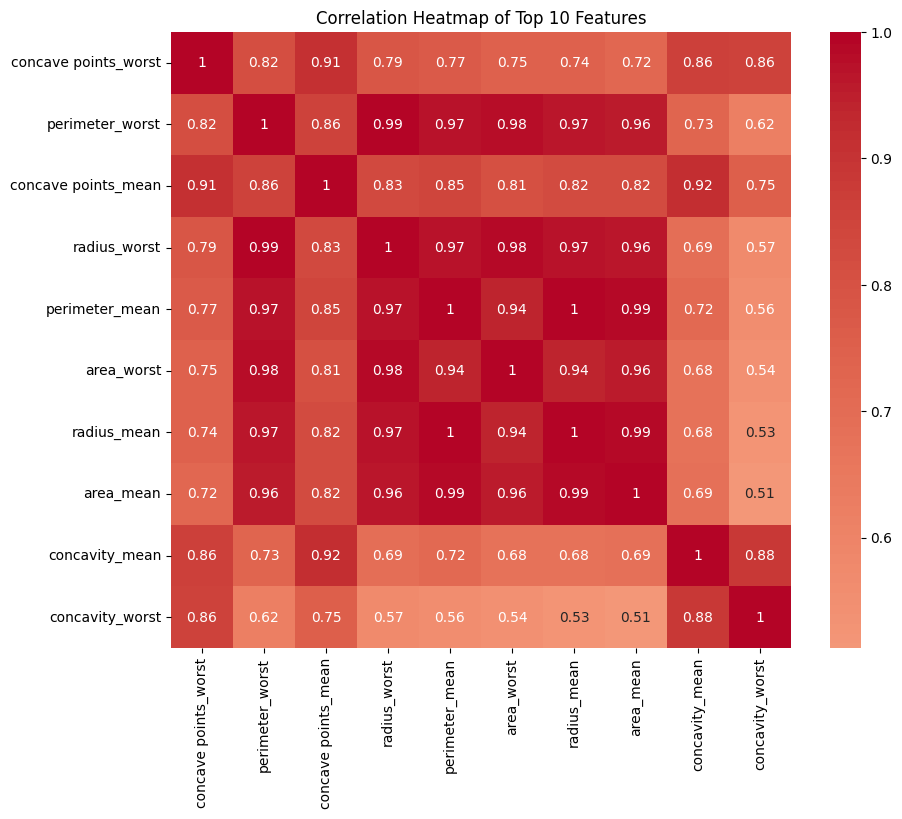

In [ ]:
print("Correlation analysis")

# Convert diagnosis to numerical for correlation
df_corr = df.copy()
df_corr['diagnosis_numeric'] = df_corr['diagnosis'].map({'M': 1, 'B': 0})

# Correlation with target
corr_with_target = df_corr.corr(numeric_only=True)['diagnosis_numeric'].sort_values(ascending=False)
print("Top 10 features correlated with diagnosis:")
print(corr_with_target.head(10))

print("\n Bottom 10 features correlated with diagnosis:")
print(corr_with_target.tail(10))

# Plot correlation heatmap for top features
top_corr_features = corr_with_target.index[1:11]  # Exclude diagnosis itself
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[top_corr_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()

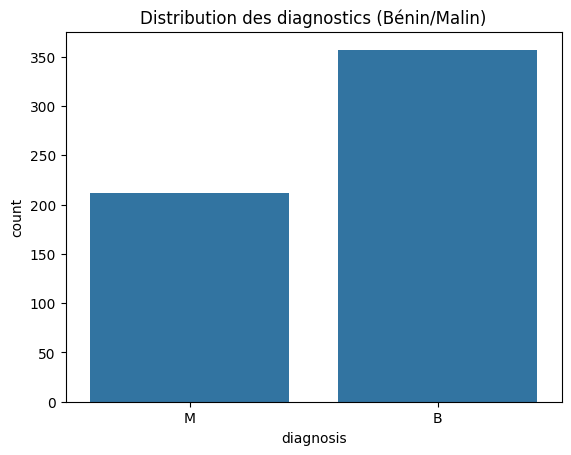

In [ ]:
sns.countplot(x="diagnosis", data=df)
plt.title("Distribution des diagnostics (Bénin/Malin)")
plt.show()

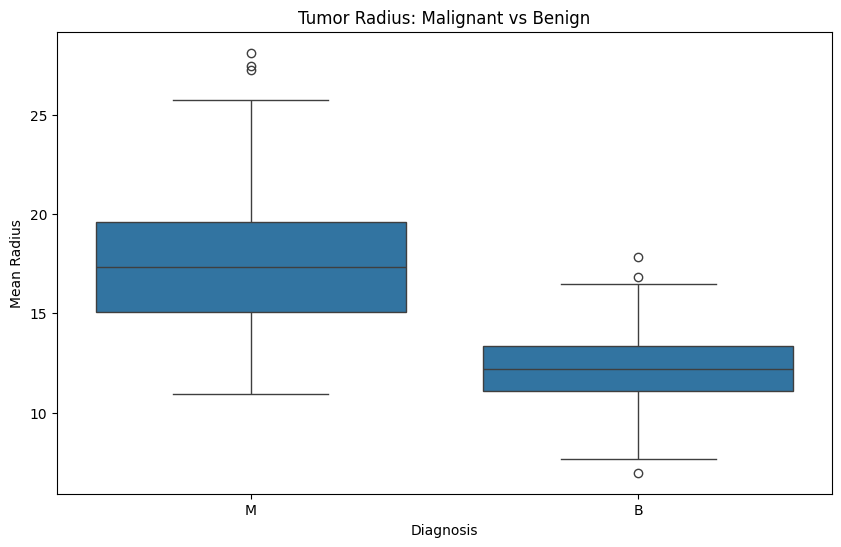

In [ ]:
# Compare a key feature between malignant and benign
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='diagnosis', y='radius_mean')
plt.title('Tumor Radius: Malignant vs Benign')
plt.ylabel('Mean Radius')
plt.xlabel('Diagnosis')
plt.show()

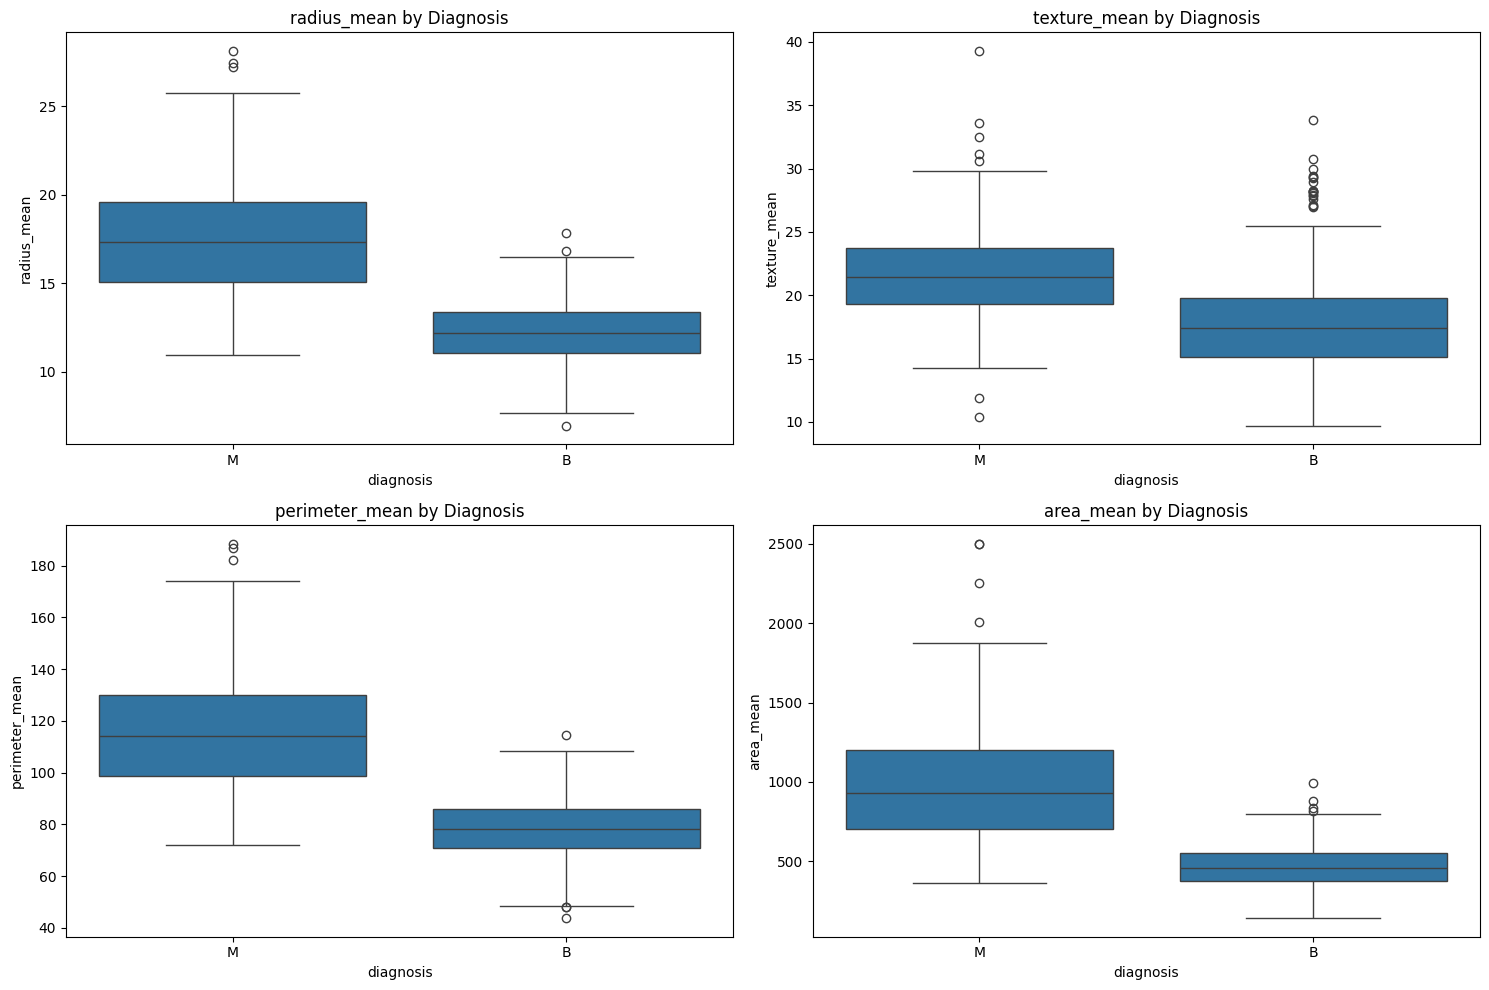

In [ ]:
# Selecting few key features to compare
features_to_plot = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df, x='diagnosis', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Diagnosis')

plt.tight_layout()
plt.show()

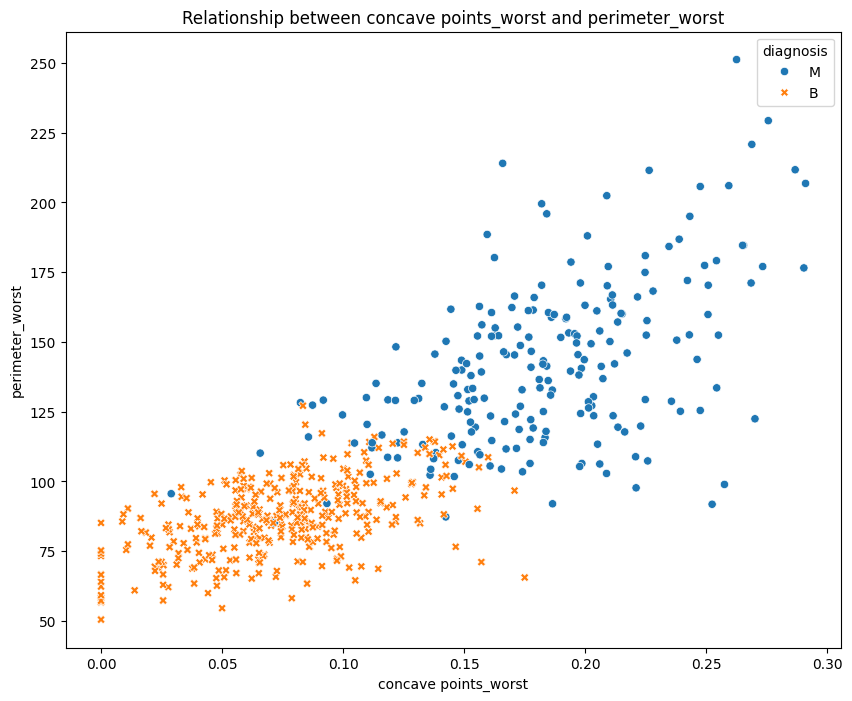

In [ ]:
# Find two features most correlated with diagnosis
top_two = corr_with_target.index[1:3]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x=top_two[0], y=top_two[1], hue='diagnosis', style='diagnosis')
plt.title(f'Relationship between {top_two[0]} and {top_two[1]}')
plt.show()

#III. Data Preparation

In [ ]:
df.drop(columns=['Unnamed: 32', 'id'], inplace=True, errors='ignore')
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
scaler = StandardScaler()
X = df.drop('diagnosis', axis=1)
y = df["diagnosis"]
X_scaled = scaler.fit_transform(X)
scores = X_scaled

In [ ]:
pca = PCA()
pca.fit(X_scaled)

PCA()

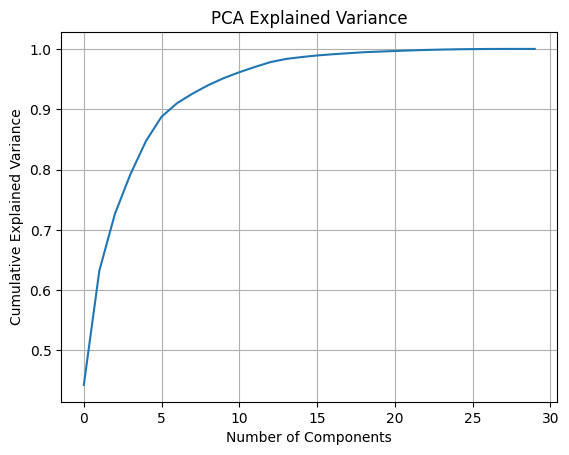

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

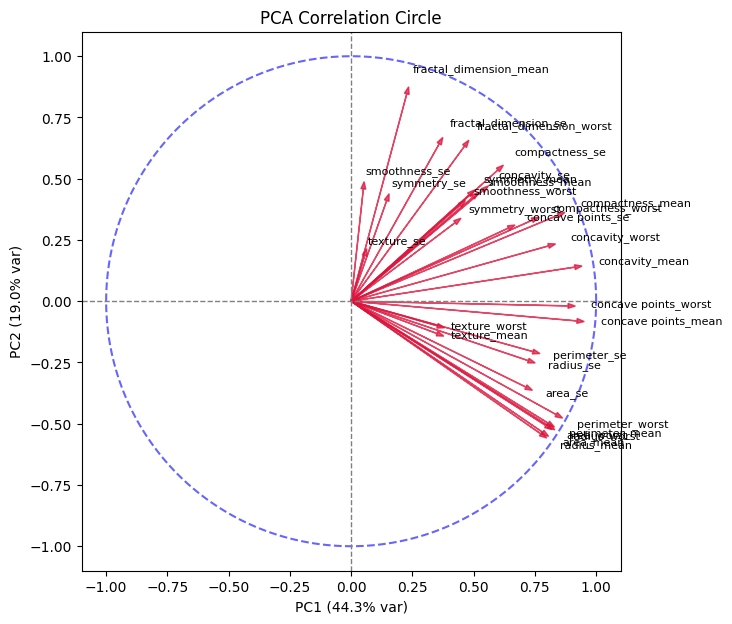

In [ ]:
eigvals = pca.explained_variance_
loadings_corr = pca.components_.T * np.sqrt(eigvals)  # shape (n_features, 2)

fig, ax = plt.subplots(figsize=(7, 7))
theta = np.linspace(0, 2*np.pi, 500)
ax.plot(np.cos(theta), np.sin(theta), 'b--', alpha=0.6)

names = X.columns
for i, name in enumerate(names):
    x, y_ = loadings_corr[i, 0], loadings_corr[i, 1]
    ax.arrow(0, 0, x, y_, color='crimson', alpha=0.75,
             head_width=0.02, length_includes_head=True)
    ax.text(x*1.07, y_*1.07, name, fontsize=8)

ax.axhline(0, color='grey', lw=1, ls='--')
ax.axvline(0, color='grey', lw=1, ls='--')
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
ax.set_title("PCA Correlation Circle")
ax.set_aspect('equal', 'box')
plt.show()

In [ ]:
pcs = [f"PC{i}" for i in range(1, scores.shape[1] + 1)]
scores_df = pd.DataFrame(scores @ pca.components_.T, columns=pcs)
scores_df["diagnosis"] = df["diagnosis"]

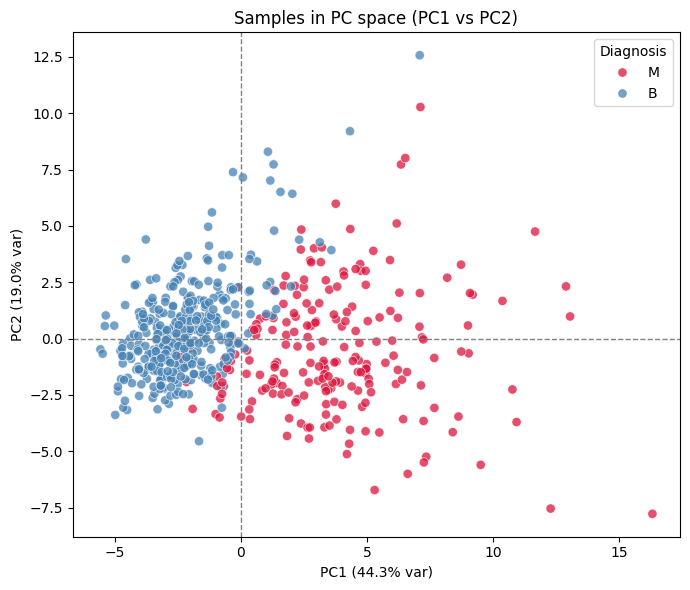

In [ ]:
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=scores_df, x="PC1", y="PC2",
    hue="diagnosis",
    palette={"M": "crimson", "B": "steelblue"},
    alpha=0.75, edgecolor="white", s=45
)
plt.axhline(0, color="grey", ls="--", lw=1)
plt.axvline(0, color="grey", ls="--", lw=1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Samples in PC space (PC1 vs PC2)")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()

#IV. Modeling

#V. Evaluation

#VI. Deployment